In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import yaml
import shutil
from datetime import datetime

In [2]:
### All global variables that would be passed as arguments in a python script
input_folders = [
    "/home/nils/Downloads/WindowManagementBM_1737725599",
    "/home/nils/Downloads/WindowManagementBM_1737725623",
    "/home/nils/Downloads/WindowManagementBM_1737725647",
    "/home/nils/Downloads/WindowManagementBM_1737725671",
    "/home/nils/Downloads/WindowManagementBM_1737725696",
    "/home/nils/Downloads/WindowManagementBM_1737725720"
]
output_folder = "/home/nils/Downloads/output_plots"
statistics_csv_name = "all_statistics.csv"
pipeline_txt_name = "pipelines.txt"
benchmark_config_file = "benchmark_config.yaml"
statistics_csv_path = os.path.join(output_folder, statistics_csv_name)


# Remove the output_folder and then create it again
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.mkdir(output_folder)


# Set the seaborn style
sns.set(style="whitegrid")

In [3]:
# Converting pipelines.txt to a dict of pipeline id to a title
def extract_pipeline_data(input_path):
    with open(input_path, 'r') as input_file:
        input_text = input_file.read()

    pipeline_dict = {}
    # Split the input text by the delimiter
    pipeline_sections = input_text.split("############################################")
    physical_pattern = re.compile(r"\bPhysical\w+")

    for section in pipeline_sections:
        # Find the pipeline ID in the section
        pipeline_match = re.search(r"Pipeline:\s*(\d+)", section)
        if pipeline_match:
            pipeline_id = int(pipeline_match.group(1))
            if pipeline_id not in pipeline_dict:
                pipeline_dict[pipeline_id] = []
            
            # Find all words starting with 'Physical' in the section
            physical_matches = physical_pattern.findall(section)
            cleaned_matches = [match.replace("Physical", "").replace("Operator", "").replace("Stream", "") for match in physical_matches]
            pipeline_dict[pipeline_id].extend(cleaned_matches)
    
    # Concatenate multiple values with "_"
    return {key: "_".join(values) for key, values in pipeline_dict.items()}

In [4]:
# Converting query engine statistics to statistics csv
pattern_worker_file = r"^worker_\d+\.txt$"
pattern_task_details = (r"(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+).*?"
       r"Task (?P<task_id>\d+) for Pipeline (?P<pipeline>\d+).*?"
       r"(?P<action>Started|Completed)(?:\. Number of Tuples: (?P<num_tuples>\d+))?")

# Gathering all statistic files across all folders
statistic_files = [(input_folder_name, os.path.join(input_folder_name, f)) for input_folder_name in input_folders for f in os.listdir(input_folder_name) if re.match(pattern_worker_file, f)]
combined_df = pd.DataFrame()
no_statistics_files = len(statistic_files)
cnt_rows = 0
for idx, [input_folder, stat_file] in enumerate(statistic_files):
    print(f"Processing {stat_file} [{idx+1}/{no_statistics_files}]")
    with open(stat_file, 'r') as file:
        log_text = file.read()

    with open(os.path.join(input_folder, benchmark_config_file), 'r') as file:
        benchmark_config_yaml = yaml.safe_load(file)
    

    records = []
    tasks = {}
    for match in re.finditer(pattern_task_details, log_text):
        timestamp = pd.to_datetime(match.group("timestamp"), format="%Y-%m-%d %H:%M:%S.%f")
        task_id = int(match.group("task_id"))
        action = match.group("action")
        num_tuples = int(match.group("num_tuples")) if match.group("num_tuples") else None
        pipeline_id = int(match.group("pipeline")) if match.group("pipeline") else None
    
        if action == "Started":
            tasks[task_id] = {"start_time": timestamp, "num_tuples": num_tuples}
        elif action == "Completed" and task_id in tasks:
            task_info = tasks[task_id]
            start_time = task_info["start_time"]
            duration = (timestamp - start_time).total_seconds()
            throughput = task_info["num_tuples"] / duration if duration > 0 else -1
            new_record = benchmark_config_yaml.copy()
            new_record['query'] = new_record['query'].replace(";", "")
            new_record.update({
                "task_id": task_id,
                "start_time": start_time,
                "end_time": timestamp,
                "duration": duration, # Seconds
                "num_tuples": task_info["num_tuples"],
                "throughput": throughput, # tup/s
                "pipeline_id": pipeline_id
            })
            
            records.append(new_record)
    
    # Create DataFrame and 
    df = pd.DataFrame(records)

    # Normalize all timestamps to the minimal start timestamp of any task
    min_start_time = df['start_time'].min()
    df['start_time_normalized'] = df['start_time'] - min_start_time
    df['end_time_normalized'] = df['end_time'] - min_start_time

    # Sorting the dataframe
    df = df.sort_values(by='task_id').reset_index(drop=True)

    # Write the created dataframe to the csv file
    df.to_csv(os.path.join(input_folder, stat_file + ".csv"), index=False)
    
    # Adding this dataframe to the global one
    cnt_rows += len(df)
    print(f"Adding {len(df)} rows to combined dataframe with an expected total no. rows of {cnt_rows}")
    combined_df = pd.concat([combined_df, df], ignore_index=True)



# Writing the combined dataframe to a csv file
combined_df.to_csv(statistics_csv_path, index=False)
print(f"Done with combining all query engine statistics to {statistics_csv_path}! No. rows: {len(combined_df)}")
combined_df.columns

Processing /home/nils/Downloads/WindowManagementBM_1737725599/worker_0.txt [1/26]
Adding 21026 rows to combined dataframe with an expected total no. rows of 21026
Processing /home/nils/Downloads/WindowManagementBM_1737725599/worker_1.txt [2/26]
Adding 21411 rows to combined dataframe with an expected total no. rows of 42437
Processing /home/nils/Downloads/WindowManagementBM_1737725599/worker_3.txt [3/26]
Adding 21748 rows to combined dataframe with an expected total no. rows of 64185
Processing /home/nils/Downloads/WindowManagementBM_1737725599/worker_5.txt [4/26]
Adding 21131 rows to combined dataframe with an expected total no. rows of 85316
Processing /home/nils/Downloads/WindowManagementBM_1737725599/worker_4.txt [5/26]
Adding 15118 rows to combined dataframe with an expected total no. rows of 100434
Processing /home/nils/Downloads/WindowManagementBM_1737725599/worker_2.txt [6/26]
Adding 21433 rows to combined dataframe with an expected total no. rows of 121867
Processing /home/nil

Index(['buffer_size_in_bytes', 'buffers_in_global_buffer_manager',
       'buffers_in_source_local_buffer_pool', 'buffers_per_worker',
       'lock_slice_cache', 'nautilus_backend', 'number_of_worker_threads',
       'query', 'slice_cache_size', 'slice_cache_type', 'slice_store_type',
       'task_queue_size', 'timestamp_increment', 'task_id', 'start_time',
       'end_time', 'duration', 'num_tuples', 'throughput', 'pipeline_id',
       'start_time_normalized', 'end_time_normalized'],
      dtype='object')

In [5]:
# Reading the combined data into dataframe named df and printing a little summary of the data frame
df = pd.read_csv(statistics_csv_path)
    
# General info
print("### DataFrame Summary ###\n")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
print("Columns and Data Types:")
print(df.dtypes, "\n")

# Number of unique values per column
print("Number of Unique Values per Column:")
print(df.nunique(), "\n")

# Check for missing values
print("Missing Values:")
print(df.isnull().sum(), "\n")

# Descriptive statistics for numeric columns
print("Descriptive Statistics (Numeric Columns):")
print(df.describe().T, "\n")

# Display a sample of rows
print("Sample Rows:")
display(df.head(5))

### DataFrame Summary ###

Shape: 1377956 rows, 22 columns

Columns and Data Types:
buffer_size_in_bytes                     int64
buffers_in_global_buffer_manager         int64
buffers_in_source_local_buffer_pool      int64
buffers_per_worker                       int64
lock_slice_cache                          bool
nautilus_backend                        object
number_of_worker_threads                 int64
query                                   object
slice_cache_size                         int64
slice_cache_type                        object
slice_store_type                        object
task_queue_size                          int64
timestamp_increment                      int64
task_id                                  int64
start_time                              object
end_time                                object
duration                               float64
num_tuples                               int64
throughput                             float64
pipeline_id            

,buffer_size_in_bytes,buffers_in_global_buffer_manager,buffers_in_source_local_buffer_pool,buffers_per_worker,lock_slice_cache,nautilus_backend,number_of_worker_threads,query,slice_cache_size,slice_cache_type,...,timestamp_increment,task_id,start_time,end_time,duration,num_tuples,throughput,pipeline_id,start_time_normalized,end_time_normalized
0,8196,1000000,1000,12800,True,COMPILER,8,SELECT * FROM tcp_source WHERE value > 5000 IN...,1,LRU,...,1,3,2025-01-24 13:33:23.485473926,2025-01-24 13:33:23.485513835,0.000039,52,1.333333e+06,2,0 days 00:00:00,0 days 00:00:00.000039909
1,8196,1000000,1000,12800,True,COMPILER,8,SELECT * FROM tcp_source WHERE value > 5000 IN...,1,LRU,...,1,17,2025-01-24 13:33:23.486270336,2025-01-24 13:33:23.486284148,0.000013,229,1.761538e+07,2,0 days 00:00:00.000796410,0 days 00:00:00.000810222
2,8196,1000000,1000,12800,True,COMPILER,8,SELECT * FROM tcp_source WHERE value > 5000 IN...,1,LRU,...,1,18,2025-01-24 13:33:23.486287082,2025-01-24 13:33:23.489261054,0.002973,121,4.069963e+04,2,0 days 00:00:00.000813156,0 days 00:00:00.003787128
3,8196,1000000,1000,12800,True,COMPILER,8,SELECT * FROM tcp_source WHERE value > 5000 IN...,1,LRU,...,1,49,2025-01-24 13:33:23.489264735,2025-01-24 13:33:23.492025311,0.002760,112,4.057971e+04,2,0 days 00:00:00.003790809,0 days 00:00:00.006551385
4,8196,1000000,1000,12800,True,COMPILER,8,SELECT * FROM tcp_source WHERE value > 5000 IN...,1,LRU,...,1,80,2025-01-24 13:33:23.492028580,2025-01-24 13:33:23.495605989,0.003577,134,3.746156e+04,2,0 days 00:00:00.006554654,0 days 00:00:00.010132063


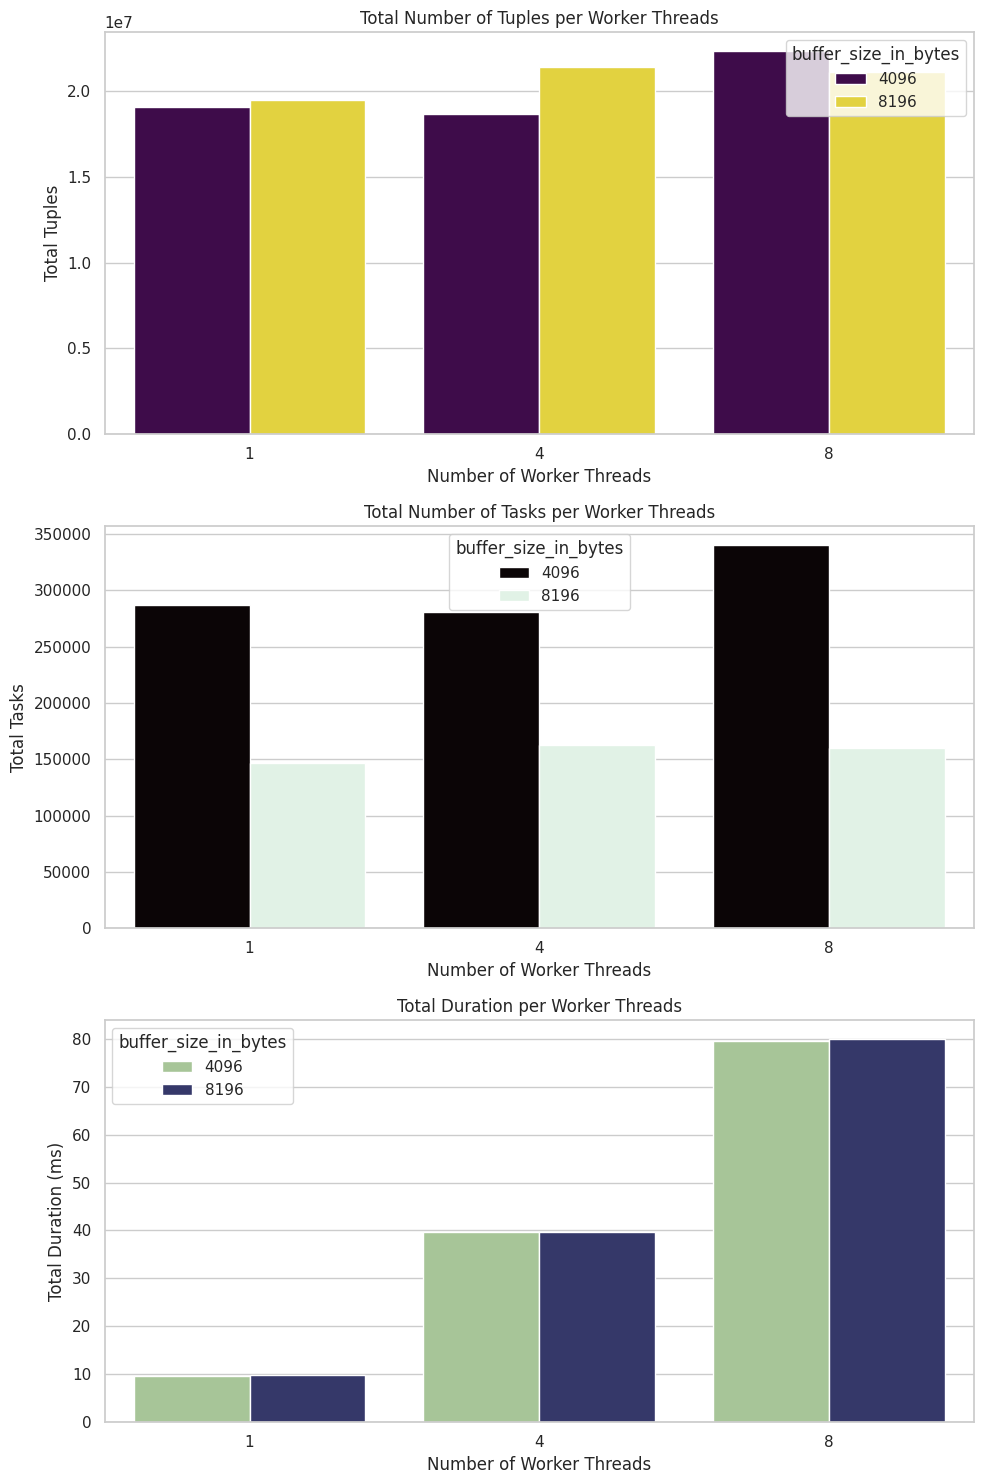

In [6]:
# Plotting the total no. tuples, no. tasks, total duration per no. worker threads

# Aggregate the data by number_of_worker_threads
aggregated_data = df.groupby(["number_of_worker_threads", "buffer_size_in_bytes"]).agg(
    total_tuples=('num_tuples', 'sum'),
    total_tasks=('task_id', 'count'),
    total_duration=('duration', 'sum')
).reset_index()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot total number of tuples
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_tuples",
    palette="viridis",
    hue="buffer_size_in_bytes",
    ax=axes[0]
)
axes[0].set_title("Total Number of Tuples per Worker Threads")
axes[0].set_xlabel("Number of Worker Threads")
axes[0].set_ylabel("Total Tuples")

# Plot total number of tasks
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_tasks",
    palette="mako",
    hue="buffer_size_in_bytes",
    ax=axes[1]
)
axes[1].set_title("Total Number of Tasks per Worker Threads")
axes[1].set_xlabel("Number of Worker Threads")
axes[1].set_ylabel("Total Tasks")

# Plot total duration
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_duration",
    palette="crest",
    hue="buffer_size_in_bytes",
    ax=axes[2]
)
axes[2].set_title("Total Duration per Worker Threads")
axes[2].set_xlabel("Number of Worker Threads")
axes[2].set_ylabel("Total Duration (ms)")

# Adjust layout
plt.tight_layout()
plt.show()
plt.close(fig)


In [7]:
df = pd.read_csv(statistics_csv_path)
group = df.groupby('number_of_worker_threads')

group.size()

number_of_worker_threads
1    434344
4    443712
8    499900
dtype: int64

In [8]:
# Plotting the throughput and duration for each pipeline in intervals
# Only do this for buffer_size_in_bytes == 8196
df = pd.read_csv(statistics_csv_path)
df = df[df['buffer_size_in_bytes'] == 8196]

# Normalize the timestamps to timedelta and milliseconds
df['start_time_normalized'] = pd.to_timedelta(df['start_time_normalized'])
df['start_time_normalized_ms'] = df['start_time_normalized'].dt.total_seconds() * 1000
df['end_time_normalized'] = pd.to_timedelta(df['end_time_normalized'])

# Create intervals
interval_size_in_ms = 500
intervals = pd.cut(df['start_time_normalized_ms'], bins=range(0, int(df['start_time_normalized_ms'].max()) + interval_size_in_ms, interval_size_in_ms), right=False)
df['interval'] = intervals
df['interval'] = df['interval'].apply(lambda x: x.left)

# Group by pipeline_id and create a plot for each group
interesting_pipeline_ids = df["pipeline_id"].unique()
df = df[df['pipeline_id'].isin(interesting_pipeline_ids)]
for pipeline_id, group in df.groupby("pipeline_id"):
    # Select only the necessary columns for computation
    group = group[['interval', 'number_of_worker_threads', 'throughput', 'duration', 'num_tuples']]
    
    sum_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=True).agg({
        'num_tuples': 'sum',
        'duration': 'sum',
    })
    # Calculate throughput as sum(num_tuples) / sum(duration)
    sum_group['throughput'] = sum_group['num_tuples'] / sum_group['duration']
    print(sum_group)


    # Calculate the average duration
    avg_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=False)['duration'].mean()

    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(16, 10))
    
    # Plot throughput vs interval
    sns.barplot(
        data=sum_group,
        x="interval",
        y="throughput",
        hue="number_of_worker_threads",
        ax=axes[0]
    )
    axes[0].set_title(f"Pipeline ID {pipeline_id}: Throughput vs Interval ({interval_size_in_ms}ms)")
    axes[0].set_xlabel("Interval")
    axes[0].set_ylabel("Throughput [tup/s]")

    # Plot duration vs interval
    sns.barplot(
        data=avg_group,
        x="interval",
        y="duration",
        hue="number_of_worker_threads",
        ax=axes[1]
    )
    axes[1].set_title(f"Pipeline ID {pipeline_id}: Duration vs Interval ({interval_size_in_ms}ms)")
    axes[1].set_xlabel("Interval")
    axes[1].set_ylabel("Duration (ms)")

    # Plot no. tuples vs interval
    sns.barplot(
        data=sum_group,
        x="interval",
        y="num_tuples",
        hue="number_of_worker_threads",
        ax=axes[2]
    )
    axes[2].set_title(f"Pipeline ID {pipeline_id}: Throughput vs Interval ({interval_size_in_ms}ms)")
    axes[2].set_xlabel("Interval")
    axes[2].set_ylabel("Num Tuples")

    # Adjust layout and save the figure
    plt.tight_layout()
    figure_path = os.path.join(output_folder, f"pipeline_{pipeline_id}_intervals_{interval_size_in_ms}ms.png")
    plt.savefig(figure_path)
    plt.close(fig)  # Close the figure to free memory



/tmp/ipykernel_97814/1808015590.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=True).agg({
/tmp/ipykernel_97814/1808015590.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=False)['duration'].mean()


                                   num_tuples  duration    throughput
interval number_of_worker_threads                                    
0        1                             987834  0.491376  2.010342e+06
         4                            1054218  1.990101  5.297309e+05
         8                            1028092  3.992787  2.574873e+05
500      1                             960126  0.490832  1.956119e+06
         4                            1048945  1.965881  5.335750e+05
...                                       ...       ...           ...
9500     4                            1073376  1.986632  5.402994e+05
         8                            1059319  3.988221  2.656119e+05
10000    1                              31487  0.020730  1.518910e+06
         4                              20189  0.053376  3.782412e+05
         8                              22679  0.128630  1.763119e+05

[63 rows x 3 columns]


In [9]:
#Plotting duration and throughput as a lineplot over the start_time_normalized
# Unique pipeline IDs
unique_pipeline_ids = df['pipeline_id'].unique()

# Generate one plot per pipeline
for pipeline_id in unique_pipeline_ids:
    # Filter data for the current pipeline_id
    pipeline_data = df[df['pipeline_id'] == pipeline_id]
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot throughput
    sns.lineplot(
        data=pipeline_data,
        x='start_time_normalized',
        y='throughput',
        hue='buffer_size_in_bytes',
        marker="o",
        ax=axes[0]
    )
    axes[0].set_title(f"Pipeline ID {pipeline_id}: Throughput vs Time")
    axes[0].set_xlabel("Start Time")
    axes[0].set_ylabel("Throughput")
    
    # Plot duration
    sns.lineplot(
        data=pipeline_data,
        x='start_time_normalized',
        y='duration',
        hue='buffer_size_in_bytes',
        marker="o",
        ax=axes[1]
    )
    axes[1].set_title(f"Pipeline ID {pipeline_id}: Duration vs Time")
    axes[1].set_xlabel("Start Time")
    axes[1].set_ylabel("Duration")
    
    # Adjust layout for readability
    plt.tight_layout()
    
    # Save the figure
    figure_path = os.path.join(output_folder, f"pipeline_{pipeline_id}.png")
    plt.savefig(figure_path)
    plt.close(fig)  # Close the figure to save memory